In [1]:
import fla  # noqa
from lm_eval.__main__ import cli_evaluate
from lm_eval.api.registry import register_model
from lm_eval.models.huggingface import HFLM

/mnt/data/zichuanfu/anaconda3/envs/flash/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# 加载模型和 tokenizer
def load_model_and_tokenizer(model_name, device="cuda"):
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained("fla-hub/gla-1.3B-100B", use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map = {"": "cuda:0"},
        # attn_implementation="eager",
    )
    return model, tokenizer

In [3]:
# model_name = "mistralai/Mistral-7B-Instruct-v0.1"
# model_name = "Qwen/Qwen2-0.5B-Instruct"
model_path = f"/mnt/data/zichuanfu/swat-attention/legacy/training/exp/transformer-340M-15B"
device = "cuda:0" if torch.cuda.is_available() else "mps"

# 加载模型和 tokenizer
model, tokenizer = load_model_and_tokenizer(model_path, device)

# model.config.sliding_window = 1024

Loading model: /mnt/data/zichuanfu/swat-attention/legacy/training/exp/transformer-340M-15B


In [4]:
# 加载和分词输入
dataset = load_dataset("emozilla/pg19", split="test", trust_remote_code=True)
text = dataset[0]["text"]  # 仅取前 16384 个字符
input_ids = tokenizer(text, return_tensors="pt", max_length=192, truncation=True).input_ids

Using the latest cached version of the dataset since emozilla/pg19 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /mnt/data/zichuanfu/.cache/huggingface/datasets/emozilla___pg19/default/0.0.0/c021754c8e01c5b1cc83a1f549c1f97fbbb756b8 (last modified on Mon Jan 20 12:42:06 2025).


In [5]:
input_ids = input_ids[:, 1:]

In [6]:
print(input_ids)

tensor([[ 5387, 28723, 14800,  1248, 16623,    13,    13,    13, 28749, 28733,
           772,  7998,   486,  8218,   473,  8144, 17760,   588, 28710,   304,
           272,  7759,   420,  8142,  4146, 10634,    13, 28757, 25625,  1133,
          1009,   923,   288,  6867,    13,    13,    13,    13,   896,  9904,
          1851, 28743, 20314,  2255,  4033,   367,  1702, 28749,   725,   384,
          3836, 28735,  2693,  5387, 28723, 14800,  1248,    13,    13, 28741,
         13079,   302,  3951,  4992, 16258,  3149,   354,   304, 22837,   297,
           272, 16955,    13, 28753,  2321,   263,  6127, 28723,    13,    13,
          1930,   401,  4943, 28796,  9875, 28762,   896,    13,    13,    13,
            13,    13,    13,    13, 19917,  3701,  2074,   725, 17235, 12894,
         28777, 20335,  4033,   367,  1702, 28749,   725,   384,  3836, 28735,
         28723,    13,    13, 28741, 19721,  7453, 28765,   418,  1087, 28754,
          4866,  4033, 27814, 20734, 28735,  5771, 1

In [7]:
# 提取注意力分数
# 模型前向
with torch.no_grad():
    output = model(input_ids.to(device), output_attentions=True, output_hidden_states=True)

q shape: torch.Size([1, 191, 16, 64])
k shape: torch.Size([1, 191, 16, 64])
attn_scores shape after matmul: torch.Size([1, 16, 191, 191])
alibi_bias shape: torch.Size([1, 16, 191, 191])
final attentions shape: torch.Size([1, 191, 16, 191])
q shape: torch.Size([1, 191, 16, 64])
k shape: torch.Size([1, 191, 16, 64])
attn_scores shape after matmul: torch.Size([1, 16, 191, 191])
alibi_bias shape: torch.Size([1, 16, 191, 191])
final attentions shape: torch.Size([1, 191, 16, 191])
q shape: torch.Size([1, 191, 16, 64])
k shape: torch.Size([1, 191, 16, 64])
attn_scores shape after matmul: torch.Size([1, 16, 191, 191])
alibi_bias shape: torch.Size([1, 16, 191, 191])
final attentions shape: torch.Size([1, 191, 16, 191])
q shape: torch.Size([1, 191, 16, 64])
k shape: torch.Size([1, 191, 16, 64])
attn_scores shape after matmul: torch.Size([1, 16, 191, 191])
alibi_bias shape: torch.Size([1, 16, 191, 191])
final attentions shape: torch.Size([1, 191, 16, 191])
q shape: torch.Size([1, 191, 16, 64])
k 

In [8]:
print(output.keys())

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])


In [9]:
print(len(output["attentions"]))

24


In [10]:
output["attentions"][0].shape

torch.Size([1, 191, 16, 191])

In [11]:
def visualize_attention_scores(
    attention_scores,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(5, 4))
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(attention_matrix, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{attention_matrix[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


# # 可视化某一层的注意力分数
# def visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file=None):
#     plt.figure(figsize=(10, 8))
#     attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
#     plt.imshow(attention_matrix, cmap="viridis", aspect="auto")
#     plt.colorbar(label="Attention Score")
#     plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
#     plt.xlabel("Key Position")
#     plt.ylabel("Query Position")
#     if output_file:
#         plt.savefig(output_file)
#     plt.show()


In [12]:

attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 3  # 可视化第几层
head_idx = 6   # 可视化第几个注意力头
seq_len = 8192  # 只显示前 1024 长度的分数（避免图太大）
visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

TypeError: Got unsupported ScalarType BFloat16

<Figure size 500x400 with 0 Axes>

In [ ]:
################################swt###############################
def visualize_all_head_avg_attention_scores(
    attention_scores,
    layer_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(5, 4))
    # attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
    
    attention_tensor = attention_scores[layer_idx][0]  # shape: (num_heads, seq_len, seq_len)
    mean_attention = attention_tensor.mean(dim=0).cpu()  # shape: (seq_len, seq_len)

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        mean_attention = torch.log(mean_attention + epsilon).numpy()
    elif norm_type == "minmax":
        mean_attention = mean_attention.numpy()
        mean_attention = (mean_attention - mean_attention.min()) / (
            mean_attention.max() - mean_attention.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(mean_attention, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{mean_attention[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


In [ ]:
################################swt###############################
attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 3  # 可视化第几层
seq_len = 8192  # 只显示前 1024 长度的分数（避免图太大）
visualize_all_head_avg_attention_scores(attention_scores, layer_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attention_and_variance(
    attention_scores,
    hidden_states,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    将布局改为：
    ┌─────────┬─────────────────┬─────────┐
    │         │   上:热力图     │         │
    │  左CB   ├─────────────────┤  右CB   │
    │         │   下:热力图     │         │
    └─────────┴─────────────────┴─────────┘
    其中 1×3 网格：左列放注意力热力图的colorbar，中间列是上下热力图(再细分为2×1)，右列放方差热力图的colorbar
    """

    # 1. 创建主图与 1×3 主网格
    fig = plt.figure(figsize=(6, 4))
    gs_main = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[0.2, 3, 0.2], wspace=0.3)

    # 2. 中间列做成 2 行 1 列的子网格，用于放置上下两个热力图
    gs_center = gs_main[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[16, 1], hspace=0.2)

    # 分别创建上、下两个 Axes
    ax_top = fig.add_subplot(gs_center[0, 0])    # 上
    ax_bottom = fig.add_subplot(gs_center[1, 0]) # 下

    # 左侧 colorbar Axes (给“上方注意力”用)
    cax_left = fig.add_subplot(gs_main[0, 0])
    # 右侧 colorbar Axes (给“下方方差”用)
    cax_right = fig.add_subplot(gs_main[0, 2])

    # 3. 处理注意力矩阵
    attention_tensor = attention_scores[layer_idx][0]  # shape: (num_heads, seq_len, seq_len)
    attention_matrix = attention_tensor.mean(dim=0).cpu()  # shape: (seq_len, seq_len)
    # attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )
    else:
        attention_matrix = attention_matrix.numpy()

    # 4. 绘制“上方”的注意力热力图
    im1 = ax_top.imshow(attention_matrix, cmap=cmap, aspect="equal", interpolation="nearest")
    ax_top.set_box_aspect(1)
    ax_top.set_title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}", pad=10)
    ax_top.set_xlabel("Token Index")
    ax_top.set_ylabel("Token Index")
    # 在右边添加额外的标签
    ax_top.text(1.1, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center")

    # 可选：矩阵数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                ax_top.text(j, i, f"{attention_matrix[i, j]:.2f}",
                            ha="center", va="center", fontsize=6)

    # 给“上方热力图”创建 colorbar，放在左侧 cax_left
    cb1 = fig.colorbar(im1, cax=cax_left, orientation='vertical')
    cb1.set_label("Attention Score")
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')

    # 5. 计算并绘制“下方”的方差热力图（单行）
    token_variances = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
    token_variances = np.expand_dims(token_variances, axis=0)  # 转为 1×N

    im2 = ax_bottom.imshow(token_variances, cmap=cmap, aspect="equal", interpolation="nearest")
    # ax_bottom.set_title(f"Token Variance for Layer {layer_idx + 1}", y=-1.5)
    # ax_bottom.set_ylabel("Variance", y=0.5, x=1.05)
    ax_bottom.text(1.1, 0.5, "Variancee", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center")
    ax_bottom.yaxis.set_label_position('right')
    ax_bottom.set_box_aspect(1/16)
    ax_bottom.set_yticks([])  # 隐藏 y 轴

    # 给“下方热力图”创建 colorbar，放在右侧 cax_right
    cb2 = fig.colorbar(im2, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance")

    # 6. 保存或者显示
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

visualize_attention_and_variance(output["attentions"], output["hidden_states"], layer_idx=3, head_idx=2, seq_len=50)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker
# 设置全局字体
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "DejaVu Serif"

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在“只有一行”的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        # attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        attn_tensor = attention_scores[layer_idx][0, :, :seq_len, :seq_len].cpu()  # (n_heads, seq, seq)
        attn_mat = attn_tensor.mean(dim=0)                                         # (seq, seq)

        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    var_min  = min(m.min() for m in all_variance_mats)
    # var_max  = max(m.max() for m in all_variance_mats)
    var_max = 500

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 3.2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[1] + [4]*num_layers + [1],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 1], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 x 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

        # -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="equal",
            interpolation="nearest"
        )
        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴
        # 下图只有 1 行 vs. seq_len 列，如果想让每个格子跟上面一样大，需要适度控制纵横比
        # 这里 height_ratios=[16,1] 已经让下方更扁，同时 aspect="equal" 让其看起来为小方格
        # 也可再对 set_box_aspect() 做精调:
        #   ax_bottom.set_box_aspect(1/16)  # 视 seq_len 的大小而定
        # ax_bottom.set_box_aspect(1/16)

        # 如果是最后一个 layer，添加右侧 text
        if i == num_layers - 1:
            ax_top.text(1.14, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center", fontsize=18)
            # ax_bottom.text(1.1, 0.5, "Variance", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center", fontsize=14)

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入“空白” ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top    - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 例如上下各留 5%:
    # 画完 colorbars 之后
    # 左右各留 5%，上下各留 10% 的空间
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.8,
                                 pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.8, pad_right=0.0,
                                 pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

layers_to_plot = [2, 3, 4, 5]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=50,
    norm_type="minmax",    # 可选: "log", "minmax", 或 None
    cmap="plasma",
    annotate=False,
    output_file="Figure 3.pdf"
)


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker

from matplotlib import font_manager as fm

# 加载字体文件
# 1. 加载本地字体文件
font_path = "./times.ttf"
my_font_prop = fm.FontProperties(fname=font_path)

# 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
fm.fontManager.addfont(font_path)

# 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
plt.rcParams["font.family"] = my_font_prop.get_name()
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.family"] = "DejaVu Serif"

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在“只有一行”的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        # attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        attn_tensor = attention_scores[layer_idx][0, :, :seq_len, :seq_len].cpu()  # (n_heads, seq, seq)
        attn_mat = attn_tensor.mean(dim=0)                                         # (seq, seq)

        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    print(attn_min)
    var_min  = min(m.min() for m in all_variance_mats)
    var_max  = max(m.max() for m in all_variance_mats)

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 3.2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[1] + [4]*num_layers + [1],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 1], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 x 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

        # -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="equal",
            interpolation="nearest"
        )
        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴
        # 下图只有 1 行 vs. seq_len 列，如果想让每个格子跟上面一样大，需要适度控制纵横比
        # 这里 height_ratios=[16,1] 已经让下方更扁，同时 aspect="equal" 让其看起来为小方格
        # 也可再对 set_box_aspect() 做精调:
        #   ax_bottom.set_box_aspect(1/16)  # 视 seq_len 的大小而定
        # ax_bottom.set_box_aspect(1/16)

        # 如果是最后一个 layer，添加右侧 text
        if i == num_layers - 1:
            ax_top.text(1.14, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center", fontsize=18)
            # ax_bottom.text(1.1, 0.5, "Variance", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center", fontsize=14)

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入“空白” ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top    - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 例如上下各留 5%:
    # 画完 colorbars 之后
    # 左右各留 5%，上下各留 10% 的空间
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.8,
                                 pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.8, pad_right=0.0,
                                 pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

layers_to_plot = [2, 3, 4, 5]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=50,
    norm_type="log",    # 可选: "log", "minmax", 或 None
    cmap="plasma",
    annotate=False,
    output_file="Figure 3swat.pdf"
)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 1. 加载本地字体文件
font_path = "./times.ttf"
my_font_prop = fm.FontProperties(fname=font_path)

# 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
fm.fontManager.addfont(font_path)

# 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
plt.rcParams["font.family"] = my_font_prop.get_name()

# 4. 打印字体名称确认
print("当前使用字体:", my_font_prop.get_name())

# 5. 测试绘图
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("This is Times New Roman", fontproperties=my_font_prop)
plt.xlabel("X Axis", fontproperties=my_font_prop)
plt.ylabel("Y Axis", fontproperties=my_font_prop)
plt.show()


Attention range: [0.0000, 1.0000]
Variance range: [0.0012, 2336.0000]


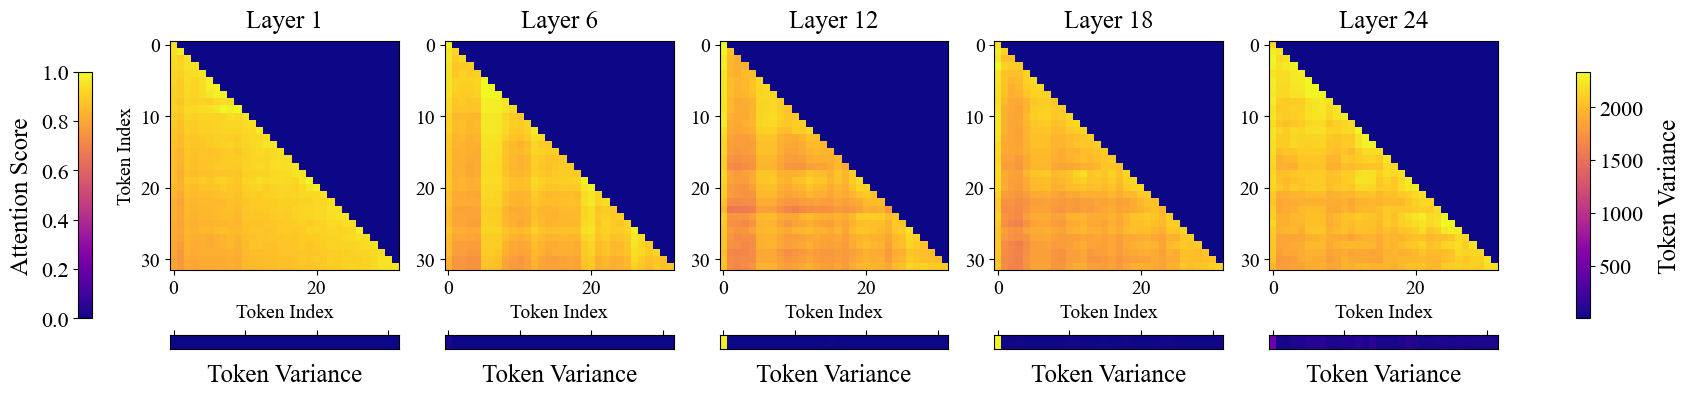

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker

from matplotlib import font_manager as fm

# 加载字体文件
# 1. 加载本地字体文件
font_path = "./times.ttf"
my_font_prop = fm.FontProperties(fname=font_path)

# 2. 手动添加这个字体到 matplotlib 的字体列表（确保优先使用它）
fm.fontManager.addfont(font_path)

# 3. 设置全局字体为该字体的名称（保证用的是你加载的本地字体）
plt.rcParams["font.family"] = my_font_prop.get_name()

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在"只有一行"的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        attn_tensor = attention_scores[layer_idx][0, :seq_len, :, :seq_len].cpu()  # (seq, n_heads, seq)
        
        # 重新排列维度: (seq, n_heads, seq) -> (n_heads, seq, seq)
        attn_tensor = attn_tensor.permute(1, 0, 2)
        
        # 转换为 float32
        attn_tensor = attn_tensor.to(torch.float32)
        
        # 处理 -inf 值：将其替换为有限值中的最小值
        mask = torch.isinf(attn_tensor)
        if mask.any():
            # 获取所有有限值
            finite_values = attn_tensor[~mask]
            if finite_values.numel() > 0:
                finite_min = finite_values.min()
                # 将 -inf 替换为比最小有限值更小的值
                attn_tensor[mask] = finite_min - 10
            else:
                # 如果没有有限值，使用默认值
                attn_tensor[mask] = -100
        
        # 计算平均
        attn_mat = attn_tensor.mean(dim=0)  # (seq, seq)
        
        # 应用归一化
        if norm_type == "log":
            epsilon = 1e-9
            # 处理负值：将所有值平移到正数范围
            if (attn_mat <= 0).any():
                attn_mat = attn_mat - attn_mat.min() + epsilon
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            valid_mask = ~torch.isnan(attn_mat)
            if valid_mask.any():
                valid_min = attn_mat[valid_mask].min()
                valid_max = attn_mat[valid_mask].max()
                if valid_max > valid_min:
                    attn_mat = (attn_mat - valid_min) / (valid_max - valid_min)
                else:
                    attn_mat = torch.zeros_like(attn_mat)
        
        # 最终检查并处理任何剩余的 NaN 或 inf
        attn_mat = torch.nan_to_num(attn_mat, nan=0.0, posinf=1.0, neginf=-1.0)
        
        attn_mat = attn_mat.cpu().numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        hidden_layer = hidden_states[layer_idx][:, :seq_len, :]
        var_mat = torch.var(hidden_layer, dim=-1).squeeze(0)
        # 转换为 float32 类型再转 numpy（解决 BFloat16 问题）
        var_mat = var_mat.to(torch.float32).cpu().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # 计算全局 min/max，排除 NaN 和 inf
    def safe_min(arrays):
        valid_mins = []
        for arr in arrays:
            valid_mask = np.isfinite(arr)
            if valid_mask.any():
                valid_mins.append(arr[valid_mask].min())
        return min(valid_mins) if valid_mins else 0.0
    
    def safe_max(arrays):
        valid_maxs = []
        for arr in arrays:
            valid_mask = np.isfinite(arr)
            if valid_mask.any():
                valid_maxs.append(arr[valid_mask].max())
        return max(valid_maxs) if valid_maxs else 1.0
    
    attn_min = safe_min(all_attention_mats)
    attn_max = safe_max(all_attention_mats)
    
    # 如果范围无效，使用默认值
    if not np.isfinite(attn_min) or not np.isfinite(attn_max) or attn_min >= attn_max:
        print(f"Warning: Invalid attention range [{attn_min}, {attn_max}], using default")
        attn_min, attn_max = 0.0, 1.0
    
    print(f"Attention range: [{attn_min:.4f}, {attn_max:.4f}]")
    
    var_min = safe_min(all_variance_mats)
    var_max = safe_max(all_variance_mats)
    print(f"Variance range: [{var_min:.4f}, {var_max:.4f}]")

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3.5 + 3.2*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[1] + [4]*num_layers + [1],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.0
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=3, ncols=1, height_ratios=[16, 0.0, 1], hspace=0.4)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}", pad=10, fontsize=18)

        ax_top.set_xlabel("Token Index", fontsize=14)
        # 如果是第一个 layer，添加 y 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index", fontsize=14)
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # 设置刻度标签大小
        ax_top.tick_params(labelsize=14)

# -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[2, 0])
        var_mat = all_variance_mats[i]
        
        # 获取上图的位置信息
        pos_top = ax_top.get_position()
        
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="auto",
            interpolation="nearest"
        )
        
        # 调整底部图的位置，使其宽度与上图一致
        pos_bottom = ax_bottom.get_position()
        ax_bottom.set_position([pos_top.x0, pos_bottom.y0, pos_top.width, pos_bottom.height])
        
        ax_bottom.set_xlabel("Token Variance", fontsize=18, labelpad=10)
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score", fontsize=18, labelpad=5)
    # 设置刻度标签大小
    cb1.ax.tick_params(labelsize=16)

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance", fontsize=18, labelpad=10)
    # 设置刻度标签大小
    cb2.ax.tick_params(labelsize=16)

    # ---------- 在这里插入"空白" ----------
    def add_axes_padding(ax,
                         pad_left=0.0, pad_right=0.0,
                         pad_top=0.0, pad_bottom=0.0):
        """
        给指定的 ax 在四个方向上各留一定比例的空白：
          pad_left   : 左边留原宽度 pad_left 倍的空白，并向右移同样的距离
          pad_right  : 右边留原宽度 pad_right 倍的空白，并缩小宽度
          pad_bottom : 底部留原高度 pad_bottom 倍的空白，并向上移同样的距离
          pad_top    : 顶部留原高度 pad_top 倍的空白，并缩小高度

        参数均为相对比例，例如 pad_left=0.1 意味着「左边留出原宽度的 10%」。
        """
        x0, y0, w, h = ax.get_position().bounds

        new_x0 = x0 + pad_left * w
        new_width = w * (1 - pad_left - pad_right)
        new_y0 = y0 + pad_bottom * h
        new_height = h * (1 - pad_top - pad_bottom)

        ax.set_position([new_x0, new_y0, new_width, new_height])

    # 左右各留 5%，上下各留 10% 的空间
    add_axes_padding(cax_left,  pad_left=0.0, pad_right=0.8,
                                pad_top=0.10,  pad_bottom=0.10)
    add_axes_padding(cax_right, pad_left=0.8, pad_right=0.0,
                                pad_top=0.10,  pad_bottom=0.10)

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

# 使用示例
layers_to_plot = [0,5,11,17,23]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=32,
    norm_type="minmax",    # 可以尝试 "minmax" 或 None
    cmap="plasma",
    annotate=False,
    output_file="Figure_3swat.pdf"
)